In [7]:
#!/usr/bin/env python
# coding: utf-8

# This script is used to compare ensemble outputs with NLDAS data
import os
os.environ["PROJ_LIB"] = '/glade/u/home/hongli/tools/miniconda3/envs/conda_hongli/share/proj'

from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pyproj import Proj
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
import xarray as xr
import datetime

startTime = datetime.datetime.now()

def read_nldas(file_dir, start_yr, end_yr):
    for yr in range(start_yr, end_yr+1):
        nldas_file = 'NLDAS_'+str(yr)+'.nc'
        nldas_path = os.path.join(file_dir, nldas_file)

        f_nldas = xr.open_dataset(nldas_path)
        if yr == start_yr:
            pcp_concat = f_nldas['pcp'].values[:] # (time, y, x). unit: mm/day
            t_mean_concat = f_nldas['t_mean'].values[:] # (time, y, x). unit: degC
            t_range_concat = f_nldas['t_range'].values[:]
            time_concat = f_nldas['time'].values[:]
        else:
            pcp_concat = np.concatenate((pcp_concat, f_nldas['pcp'].values[:]), axis = 0)
            t_mean_concat = np.concatenate((t_mean_concat, f_nldas['t_mean'].values[:]), axis = 0)
            t_range_concat = np.concatenate((t_range_concat, f_nldas['t_range'].values[:]), axis = 0)
            time_concat = np.concatenate((time_concat, f_nldas['time'].values[:]), axis = 0)

    # get time mask from nldas data
    time_obj = pd.to_datetime(time_concat)
    return time_obj, pcp_concat, t_mean_concat, t_range_concat

def read_ens_mb(file_dir, mb, start_yr, end_yr):
    for yr in range(start_yr, end_yr+1):        
        
        filename='ens_forc.%d.%03d.nc'%(yr,mb)
        file = os.path.join(file_dir, filename)
        f=xr.open_dataset(file)
        time = f['time'].values[:]
        pcp = f['pcp'].values[:]
        tmean = f['t_mean'].values[:]
        trange = f['t_range'].values[:]
        
        if yr == start_yr:
            time_concat = time
            pcp_concat = pcp
            tmean_concat = tmean
            trange_concat = trange
        else:
            time_concat = np.concatenate((time_concat,time), axis=0) # (time)
            pcp_concat = np.concatenate((pcp_concat, pcp), axis=0) # (time,y,x)
            tmean_concat = np.concatenate((tmean_concat, tmean), axis=0)
            trange_concat = np.concatenate((trange_concat, trange), axis=0)            
    time_concat = pd.to_datetime(time_concat)        
    return time_concat, pcp_concat, tmean_concat, trange_concat

def read_regress_std(file_dir, start_yr, end_yr):
    for yr in range(start_yr, end_yr+1):        
        
        filename='regress_ts.%d.nc'%(yr)
        file = os.path.join(file_dir, filename)
        f=xr.open_dataset(file)
        time = f['time'].values[:]
        pcp_error = f['pcp_error'].values[:] # std
        tmean_error_2 = f['tmean_error_2'].values[:]
        trange_error_2 = f['trange_error_2'].values[:]
        
        if yr == start_yr:
            time_concat = time
            pcp_error_concat = pcp_error
            tmean_error_2_concat = tmean_error_2
            trange_error_2_concat = trange_error_2
        else:
            time_concat = np.concatenate((time_concat,time), axis=0) # (time)
            pcp_error_concat = np.concatenate((pcp_error_concat, pcp_error), axis=0) # (time,y,x)
            tmean_error_2_concat = np.concatenate((tmean_error_2_concat, tmean_error_2), axis=0)
            trange_error_2_concat = np.concatenate((trange_error_2_concat, trange_error_2), axis=0)
            
    time_concat = pd.to_datetime(time_concat)        
    return time_concat, pcp_error_concat, tmean_error_2_concat, trange_error_2_concat

def read_ens_std(file_dir, start_yr, end_yr):
    for yr in range(start_yr, end_yr+1):        
        
        filename='ens_forc.%d.ensstd.nc'%(yr)
        file = os.path.join(file_dir, filename)
        f=xr.open_dataset(file)
        time = f['time'].values[:]
        pcp_error = f['pcp'].values[:] # std
        tmean_error = f['t_mean'].values[:]
        trange_error = f['t_range'].values[:]
        
        if yr == start_yr:
            time_concat = time
            pcp_error_concat = pcp_error
            tmean_error_concat = tmean_error
            trange_error_concat = trange_error
        else:
            time_concat = np.concatenate((time_concat,time), axis=0) # (time)
            pcp_error_concat = np.concatenate((pcp_error_concat, pcp_error), axis=0) # (time,y,x)
            tmean_error_concat = np.concatenate((tmean_error_concat, tmean_error), axis=0)
            trange_error_concat = np.concatenate((trange_error_concat, trange_error), axis=0)
            
    time_concat = pd.to_datetime(time_concat)        
    return time_concat, pcp_error_concat, tmean_error_concat, trange_error_concat

def plot_basemap(llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat,ax,lat_0,lon_0,ny,nx):

    m = Basemap(llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat,resolution='l',projection='cyl', ax=ax)   
#     m = Basemap(llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat,resolution='l',projection='tmerc', ax=ax,lat_0=lat_0,lon_0=lon_0)

    m.drawstates(linewidth=0.5, linestyle='solid', color='grey')
    m.drawcountries(linewidth=0.5, linestyle='solid', color='k')
    m.drawcoastlines(linewidth=.25, linestyle='solid', color='k')
    return m

def create_colormap(cmap):
    # create a white-cmap linear colormap
    # reference: https://stackoverflow.com/questions/25408393/getting-individual-colors-from-a-color-map-in-matplotlib
    cmap = mpl.cm.get_cmap(cmap) #‘viridis’，'jet' # get the blue color of jet 
    c0 = cmap(0.0)
#     top = mpl.colors.LinearSegmentedColormap.from_list("", ["white",c0])
    top = mpl.colors.LinearSegmentedColormap.from_list("", ["white","white"])

    # combine two liner colormaps to create a
    # reference: https://matplotlib.org/3.1.0/tutorials/colors/colormap-manipulation.html
    bottom = mpl.cm.get_cmap(cmap) #'jet','viridis'
    newcolors = np.vstack((top(np.linspace(0, 1, int(256*0.01))),bottom(np.linspace(0, 1, int(256*0.99)))))
    newcmp = mpl.colors.LinearSegmentedColormap.from_list("NewCmap", newcolors)
    return newcmp

# set the colormap and centre the colorbar
class MidpointNormalize(mpl.colors.Normalize):
    """Normalise the colorbar.
    source: http://chris35wills.github.io/matplotlib_diverging_colorbar/
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-300, vmax=1000))    
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

#======================================================================================================
# main script
root_dir = '/glade/u/home/hongli/scratch/2020_04_21nldas_gmet'   
nldas_dir = os.path.join(root_dir,'data/nldas_daily_utc_convert')
start_yr = 2016
end_yr = 2016

gridinfo_file = os.path.join(root_dir,'data/nldas_topo/conus_ens_grid_eighth.nc')

result_dir = os.path.join(root_dir,'test_uniform_perturb')
test_folders = [d for d in os.listdir(result_dir)]
test_folders = sorted(test_folders)

regress_subforlder = 'gmet_regr'
ens_subforlder = 'gmet_ens_bc'
ens_stat_subforlder='gmet_ens_bc_summary'

ens_num = 100
time_format = '%Y-%m-%d'

dpi_value = 150
plot_date_start = '2016-06-01'
plot_date_end = '2016-06-30'
plot_date_start_obj = datetime.datetime.strptime(plot_date_start, time_format)
plot_date_end_obj = datetime.datetime.strptime(plot_date_end, time_format)

output_dir=os.path.join(root_dir, 'scripts/step33_plot_spatial_mbm_std')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
#======================================================================================================
print('Read gridinfo mask')
# get xy mask from gridinfo.nc
f_gridinfo = xr.open_dataset(gridinfo_file)
mask_xy = f_gridinfo['mask'].values[:] # (y, x). 1 is valid. 0 is invalid.
#data_mask = f_gridinfo['data_mask'].values[:] # (y, x). 1 is valid. 0 is invalid.
latitude = f_gridinfo['latitude'].values[:]
longitude = f_gridinfo['longitude'].values[:]

#======================================================================================================
# read historical nldas data
print('Read nldas data')
time_obj, pcp, tmean, trange=read_nldas(nldas_dir,start_yr, end_yr)
mask_t  = (time_obj >= plot_date_start_obj) & (time_obj <= plot_date_end_obj) 
time = time_obj[mask_t]

# time series mean
pcp_mean = np.nanmean(pcp[mask_t,:,:], axis=0) #(y, x))
tmean_mean = np.nanmean(tmean[mask_t,:,:], axis=0) 
trange_mean = np.nanmean(trange[mask_t,:,:], axis=0)

# convert masked values to nan
pcp_mean=np.where(mask_xy==0,np.nan,pcp_mean)
tmean_mean=np.where(mask_xy==0,np.nan,tmean_mean)
trange_mean=np.where(mask_xy==0,np.nan,trange_mean)

# del pcp,tmean,trange

#======================================================================================================    
# create a white-jet linear colormap1
print('create colormaps')
newcmp1 = create_colormap(mpl.cm.get_cmap('jet_r'))
newcmp2 = create_colormap(mpl.cm.get_cmap('jet'))

#======================================================================================================
print('Plot')
# loop through all uniform tests
for test_folder in test_folders[-1:]:
    
    print(test_folder)
    test_dir = os.path.join(result_dir, test_folder)

    ## part 1. read data
    # read ensemble member 011  
    file_dir = os.path.join(test_dir,ens_subforlder)
    mb1 = 11
    time_mb1, pcp_mb1, tmean_mb1, trange_mb1 = read_ens_mb(file_dir, mb1, start_yr, end_yr)

    # read ensemble member 075 
    file_dir = os.path.join(test_dir,ens_subforlder)
    mb2 = 75
    time_mb2, pcp_mb2, tmean_mb2, trange_mb2 = read_ens_mb(file_dir, mb2, start_yr, end_yr)
    
#     # read std from regression results (method 1)    
#     file_dir = os.path.join(test_dir,regress_subforlder)
#     time_std, pcp_std, tmean_std, trange_std = read_regress_std(file_dir, start_yr, end_yr)   
    # read std from ensemble results (method 2)    
    file_dir = os.path.join(test_dir,ens_stat_subforlder)
    time_std, pcp_std, tmean_std, trange_std = read_ens_std(file_dir, start_yr, end_yr)   

    ## part 2. calcualte time-series mean for extract period
    # define plot mask for nldas ensemble
    mb1_mask_t = (time_mb1>=plot_date_start_obj) & (time_mb1<=plot_date_end_obj)
    mb2_mask_t = (time_mb2>=plot_date_start_obj) & (time_mb2<=plot_date_end_obj)
    std_mask_t = (time_std>=plot_date_start_obj) & (time_std<=plot_date_end_obj)
    
    # caluclate time series mean(ny,nx)
    pcp_mb1_mean = np.nanmean(pcp_mb1[mb1_mask_t,:,:],axis=0) 
    pcp_mb2_mean = np.nanmean(pcp_mb2[mb2_mask_t,:,:],axis=0) 
    pcp_std_mean = np.nanmean(pcp_std[std_mask_t,:,:],axis=0) 
    
    tmean_mb1_mean = np.nanmean(tmean_mb1[mb1_mask_t,:,:],axis=0) 
    tmean_mb2_mean = np.nanmean(tmean_mb2[mb2_mask_t,:,:],axis=0) 
    tmean_std_mean = np.nanmean(tmean_std[std_mask_t,:,:],axis=0) 
    
    trange_mb1_mean = np.nanmean(trange_mb1[mb1_mask_t,:,:],axis=0) 
    trange_mb2_mean = np.nanmean(trange_mb2[mb2_mask_t,:,:],axis=0) 
    trange_std_mean = np.nanmean(trange_std[std_mask_t,:,:],axis=0) 

    # convert masked values to nan
    pcp_mb1_mean=np.where(mask_xy==0,np.nan,pcp_mb1_mean)
    pcp_mb2_mean=np.where(mask_xy==0,np.nan,pcp_mb2_mean)
    pcp_std_mean=np.where(mask_xy==0,np.nan,pcp_std_mean)
    
    tmean_mb1_mean=np.where(mask_xy==0,np.nan,tmean_mb1_mean)
    tmean_mb2_mean=np.where(mask_xy==0,np.nan,tmean_mb2_mean)
    tmean_std_mean=np.where(mask_xy==0,np.nan,tmean_std_mean)
    
    trange_mb1_mean=np.where(mask_xy==0,np.nan,trange_mb1_mean)
    trange_mb2_mean=np.where(mask_xy==0,np.nan,trange_mb2_mean)
    trange_std_mean=np.where(mask_xy==0,np.nan,trange_std_mean)
    
    ## part 3. setup plot colorbar range for the plot_date
    vmin_pcp=np.nanmin([np.nanmin(pcp_mean), np.nanmin(pcp_mb1_mean), np.nanmin(pcp_mb2_mean)])
    vmax_pcp=np.nanmax([np.nanmax(pcp_mean), np.nanpercentile(pcp_mb1_mean,99.5), np.nanpercentile(pcp_mb2_mean,99.5)])
    vmin_pcp_std=np.nanmin(pcp_std_mean)
    vmax_pcp_std=np.nanpercentile(pcp_std_mean,99.5) #np.nanmax(pcp_std_mean)
    
    vmin_tmean=np.nanmin([np.nanmin(tmean_mb1_mean), np.nanmin(tmean_mb2_mean)])
    vmax_tmean=np.nanmax([np.nanmax(tmean_mb1_mean), np.nanmax(tmean_mb2_mean)])
    vmin_tmean_std=np.nanmin(tmean_std_mean)
    vmax_tmean_std=np.nanpercentile(tmean_std_mean,99.5) #np.nanmax(tmean_std_mean)
    
    vmin_trange=np.nanmin([np.nanmin(trange_mb1_mean), np.nanmin(trange_mb2_mean)])
    vmax_trange=np.nanmax([np.nanmax(trange_mb1_mean), np.nanmax(trange_mb2_mean)])
    vmin_trange_std=np.nanmin(trange_std_mean)
    vmax_trange_std=np.nanpercentile(trange_std_mean,99.5) #np.nanmax(trange_std_mean)

    # plot
    nrow = 4+2 # NLDAS, ensmb1, ensmb2, std + 2 colorbars
    ncol = 3 # Prcip, Tmean, Trange    
    fig, ax = plt.subplots(nrow, ncol, figsize=(7.08,7.08*0.85),
                          gridspec_kw={"height_ratios":[1, 1, 1, 0.05, 1, 0.05]}) #7.08*0.9
    # figure size (width, height) 
    #constrained_layout=True
#     fig.subplots_adjust(top=0.9) # adjust the subplots, i.e. leave more space at the top to accomodate the additional titles
    fig.subplots_adjust(left=0.1, bottom=0.1, right=1, top=0.85)#, wspace=None, hspace=None)
    
    llcrnrlon = longitude[0,0]
    urcrnrlon = longitude[-1,-1]
    llcrnrlat = latitude[0,0]
    urcrnrlat = latitude[-1,-1]
    lat_0=0.5*(llcrnrlat+urcrnrlat)
    lon_0=0.5*(llcrnrlon+urcrnrlon)
    (ny,nx)=np.shape(longitude)

    ylabels=['NLDAS','Member '+str(mb1),'Member '+str(mb2),'','Std. dev.','']
    
    for j in range(ncol):
        for i in range(nrow):
    
            # select data for each subplot
            # PCP (1st column, 1st-3st row)
            if j==0:
                if i <3:
#                     newcmap = create_colormap(plt.cm.jet_r)
#                     cmap=newcmap 
                    cmap=plt.cm.terrain #plt.cm.jet_r
                    vmin=vmin_pcp
                    vmax=vmax_pcp
                    if i == 0:
                        data,title_str=pcp_mean,'Precip'
                    elif i==1:
                        data=pcp_mb1_mean
                    elif i==2:
                        data=pcp_mb2_mean
                elif i==3+1:
                    cmap=plt.cm.Blues
                    vmin=vmin_pcp_std
                    vmax=vmax_pcp_std
                    data=pcp_std_mean                

            # Tmean (2st column, 1st-3st row)
            if j==1:
                if i <3:
                    cmap=plt.cm.jet 
                    vmin=vmin_tmean
                    vmax=vmax_tmean
                    if i == 0:
                        data=tmean_mean
                        title_str = 'Tmean'
                    elif i==1:
                        data=tmean_mb1_mean
                    elif i==2:
                        data=tmean_mb2_mean
                elif i==3+1:
                    cmap=plt.cm.Blues
                    vmin=vmin_tmean_std
                    vmax=vmax_tmean_std
                    data=tmean_std_mean 

            # Trange (2st column, 1st-3st row)
            if j==2:
                if i <3:
                    cmap=plt.cm.jet 
                    vmin=vmin_trange
                    vmax=vmax_trange
                    if i == 0:
                        data=trange_mean
                        title_str = 'Trange'
                    elif i==1:
                        data=trange_mb1_mean
                    elif i==2:
                        data=trange_mb2_mean
                elif i==3+1:
                    cmap=plt.cm.Blues
                    vmin=vmin_trange_std
                    vmax=vmax_trange_std
                    data=trange_std_mean 

            # plot Basemap
            if i <3 or i == 3+1:
                m = plot_basemap(llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat,ax[i,j],lat_0,lon_0,ny,nx) # plot Basemap 
            
                # plot data
                im = m.pcolormesh(longitude,latitude,data,shading='flat',latlon=True,cmap=cmap,vmin=vmin,vmax=vmax)

                # set ylabel
                if j == 0:
                    ax[i,j].set_ylabel(ylabels[i], fontsize='xx-small', fontweight='semibold')
            
            # set colorbar
            if i == 3 or i == 5:
                if i == 3 and j == 0:
                    cbar_ax, cbar_label = ax[0:3,j], '(mm/day)'
                elif i ==3 and j >=1:
                    cbar_ax, cbar_label = ax[0:3,j], '($^\circ$C)'
                elif i ==5 and j ==0:
                    cbar_ax, cbar_label = ax[4,j], '(mm/day)'
                elif i ==5 and j >=1:
                    cbar_ax, cbar_label = ax[4,j], '($^\circ$C)'

                cbar = fig.colorbar(im,cax=ax[i,j],ax=cbar_ax,pad=0.01,orientation="horizontal")  
                cbar.ax.tick_params(labelsize='xx-small',pad=0.05, length=2)             
                cbar.set_label(label=cbar_label, size='xx-small', rotation='horizontal', labelpad=-0.5)

            # set title
            if i == 0:
                ax[i,j].set_title(title_str, fontsize='xx-small', fontweight='semibold')
    
    # save plot
    fig.tight_layout(pad=0.2)
    output_filename = test_folder+'.png'
    fig.savefig(os.path.join(output_dir, output_filename), dpi=dpi_value)
    plt.close(fig)

print('Done')


Plot
Done


<ipython-input-7-0470993a05e2>:252: RuntimeWarning: Mean of empty slice
  pcp_mb1_mean = np.nanmean(pcp_mb1[mb1_mask_t,:,:],axis=0)
<ipython-input-7-0470993a05e2>:253: RuntimeWarning: Mean of empty slice
  pcp_mb2_mean = np.nanmean(pcp_mb2[mb2_mask_t,:,:],axis=0)
<ipython-input-7-0470993a05e2>:256: RuntimeWarning: Mean of empty slice
  tmean_mb1_mean = np.nanmean(tmean_mb1[mb1_mask_t,:,:],axis=0)
<ipython-input-7-0470993a05e2>:257: RuntimeWarning: Mean of empty slice
  tmean_mb2_mean = np.nanmean(tmean_mb2[mb2_mask_t,:,:],axis=0)
<ipython-input-7-0470993a05e2>:260: RuntimeWarning: Mean of empty slice
  trange_mb1_mean = np.nanmean(trange_mb1[mb1_mask_t,:,:],axis=0)
<ipython-input-7-0470993a05e2>:261: RuntimeWarning: Mean of empty slice
  trange_mb2_mean = np.nanmean(trange_mb2[mb2_mask_t,:,:],axis=0)
<ipython-input-7-0470993a05e2>:262: RuntimeWarning: Mean of empty slice
  trange_std_mean = np.nanmean(trange_std[std_mask_t,:,:],axis=0)


In [3]:
np.where(trange_mean<0)

<ipython-input-3-65a1d1ae9a87>:1: RuntimeWarning: invalid value encountered in less
  np.where(trange_mean<0)


(array([], dtype=int64), array([], dtype=int64))

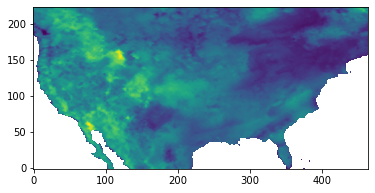

In [16]:
plt.imshow(trange_mb1[0,:,:],origin=1)

In [22]:
tmean_mb1_t0=tmean_mb1[0,:,:]
trange_mb1_t0=trange_mb1[0,:,:]
np.nanmin(trange_mb1_t0),tmean_mb1_t0[np.where(trange_mb1_t0==np.nanmin(trange_mb1_t0))]

(-0.44587624311447094, array([12.647611], dtype=float32))

In [23]:
file_dir = os.path.join(test_dir,'gmet_ens')
mb1 = 11
time_mb1_origin, pcp_mb1_origin, tmean_mb1_origin, trange_mb1_origin = read_ens_mb(file_dir, mb1, start_yr, end_yr)


In [24]:
tmean_mb1_t0_origin=tmean_mb1_origin[0,:,:]
trange_mb1_t0_origin=trange_mb1_origin[0,:,:]
np.nanmin(trange_mb1_t0_origin),tmean_mb1_t0_origin[np.where(trange_mb1_t0_origin==np.nanmin(trange_mb1_t0_origin))]

(2.0,
 array([ 21.410004,  25.63192 ,  25.620785, ..., -11.649231, -12.021039,
        -12.053965], dtype=float32))

In [26]:
np.where(trange_mb1_origin<0)

<ipython-input-26-725c7b5ca1fe>:1: RuntimeWarning: invalid value encountered in less
  np.where(trange_mb1_origin<0)


(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))